# Nick Ouellet and Garrett Gilliom - Modeling K-12 Student Test Scores Based on District Data <br/>[https://nickouellet.github.io](https://nickouellet.github.io)

## Project Goals
The team, **Nick Ouellet and Garrett Gilliom**, will be investigating data sets related to  public school districts that measure student, faculty, and staff demographics, performance, district finances, and more. So far, the team has come across two data sets that measure different variables and attributes of the Louisiana school districts across the same year that appear to be well-populated.

The following tutorial will investigate the following questions:
* Is there any correlation between student demographics, including sex, gender, race, and/or ethnicity, and testing scores?
* How important a role does teacher compensation play in testing scores?
* Which areas are most effective at promoting successful test scores? For example, does allocating money to extracuricilars like sports aid or hinder testing scores?
* Louisiana is consistently ranked as a low-performing state, education-wise. What differences exist between Louisiana and other high-performaing states that may highlight why Louisiana is ranked as such?

### Collaboration Plan
The team plans to meet once a week to work on this project to finalize our project vision, determine objectives, and assist each other where necessary. We will also be communicating thoroughly over text messages to keep each other updated with task progress and will be using Google Docs to keep an ongoing list of to-do items that’s accessible by each of us at all times. The team has also set up a shared Github repository to store, coordinate, and update our code.

In [557]:
import pandas as pd 
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_rows", None, "display.max_columns", None)

## Table 1: 
This first table is from the [U.S. Department of Education National Center for Education Statistics Common Code of Data (CCD)](https://nces.ed.gov/ccd/elsi/tableGenerator.aspx). Their website allows users to make specific queries to their database to get personalized data; the team opted to focus on Louisiana public school districts, each of which is its own observation and row, and included nearly all variable measurements to be included for each district, including diversity levels within the district, pupil/teacher ratio, total revenue from different sources, and expenditures. The team chose this data set because it provides data on many points and variables that may be relevant upon further investigation

In [558]:
info_df = pd.read_csv(r'LA_districts_2017.csv') #import financial/teacher/pupil info per district of LA
info_df.head()

,Agency Name,State Name [District] Latest available year,State Name [District] 2016-17,Agency Name [District] 2016-17,Agency Type [District] 2016-17,Total Students All Grades (Includes AE) [District] 2016-17,Male Students [District] 2016-17,Female Students [District] 2016-17,American Indian/Alaska Native - male [District] 2016-17,American Indian/Alaska Native - female [District] 2016-17,Asian or Asian/Pacific Islander - male [District] 2016-17,Asian or Asian/Pacific Islander - female [District] 2016-17,Hispanic - male [District] 2016-17,Hispanic - female [District] 2016-17,Black or African American - male [District] 2016-17,Black or African American - female [District] 2016-17,White - male [District] 2016-17,White - female [District] 2016-17,Nat. Hawaiian or Other Pacific Isl. - male [District] 2016-17,Nat. Hawaiian or Other Pacific Isl. - female [District] 2016-17,Two or More Races - male [District] 2016-17,Two or More Races - female [District] 2016-17,Full-Time Equivalent (FTE) Teachers [District] 2016-17,Pupil/Teacher Ratio [District] 2016-17,Kindergarten Teachers [District] 2016-17,Elementary Teachers [District] 2016-17,Secondary Teachers [District] 2016-17,Total Staff [District] 2016-17,Total General Revenue (TOTALREV) [District Finance] 2016-17,Total Revenue - Federal Sources (TFEDREV) [District Finance] 2016-17,Total Revenue - State Sources (TSTREV) [District Finance] 2016-17,Total Revenue - Local Sources (TLOCREV) [District Finance] 2016-17,Total Revenue (TOTALREV) per Pupil (V33) [District Finance] 2016-17,Instruction Expenditures - Total (E13) [District Finance] 2016-17,Salary - Instruction Expenditures (Z33) [District Finance] 2016-17
0,A.E. PHILLIPS LABORATORY SCHOOL,Louisiana,LOUISIANA,A.E. Phillips Laboratory School,8-Other education agencies,394,194,195,–,–,5,5,3,1,41,41,148,149,–,–,–,1,22.00,17.91,2.50,18.50,1.00,25.00,–,–,–,–,"=""0""",–,–
1,ABRAMSON SCI ACADEMY,LOUISIANA,LOUISIANA,RSD-Collegiate Academies,7-Independent Charter District,561,307,253,1,–,21,21,5,2,268,221,8,5,1,2,3,3,36.99,15.17,†,†,36.99,83.74,8252000,1397000,3605000,3250000,14709,3473000,2588000
2,ACADIA PARISH,Louisiana,LOUISIANA,Acadia Parish,1-Regular local school district that is NOT a ...,9839,5050,4787,9,9,9,5,149,115,1339,1212,3347,3233,–,–,198,214,548.94,17.92,39.00,322.36,163.58,1119.35,95051000,15149000,53342000,26560000,9661,54183000,35390000
3,ACADIANA RENAISSANCE CHARTER ACADEMY,LOUISIANA,LOUISIANA,Acadiana Renaissance Charter Academy,7-Independent Charter District,887,430,454,1,3,3,4,20,15,39,46,367,388,–,–,1,–,53.08,16.71,6.95,27.16,18.97,86.36,8941000,433000,3525000,4983000,10080,4328000,3089000
4,ADVANTAGE CHARTER ACADEMY,LOUISIANA,LOUISIANA,Advantage Charter Academy,7-Independent Charter District,553,279,267,–,1,–,–,8,6,268,253,7,10,–,–,–,–,34.30,16.12,5.27,23.03,6.00,67.63,6703000,753000,2952000,2998000,12121,2891000,1776000


This data table not only includes parish (equivalent to districts) information, but information about each school. Because we only wish to study parish data, we will drop the rest of the columns.

In [559]:
def check_parish(entry):
    if re.search(r'PARISH',entry) == None:
        return "not a parish"
    return entry

In [560]:
info_df['Agency Name'] = info_df['Agency Name'].apply(check_parish) #mark all entries that are no parishes
info_df = info_df[info_df["Agency Name"] != "not a parish"]
print(len(info_df)) #we know we have succedded because there are 64 entries and 64 parishes in LA

64


We are only studying Louisiana schools, so will will drop the columns that give us redundant data (namely 'State Name [District] Latest available year' and 'State Name [District] 2016-17'). We will also drop 'Agency Name [District]' column because we already are representing that info and 'Agency Type [District] 2016-17' because we know we are only dealing with districts.

In [561]:
info_df.drop(columns = ["State Name [District] Latest available year", "State Name [District] 2016-17", "Agency Name [District] 2016-17","Agency Type [District] 2016-17"], inplace = True)
info_df = info_df.reset_index(drop=True) #reset the numberical index to be 0-63 to accomidate for dropped rows


Now we will rename certain columns to remove excess wording.

In [562]:
info_df = info_df.rename(columns = { "Agency Name": "Parish",
                                     "Total Students All Grades (Includes AE) [District] 2016-17":"Total Students",
                                     'Male Students [District] 2016-17': "Male Students",
                                     'Female Students [District] 2016-17':"Female Students", 
                                     'American Indian/Alaska Native - male [District] 2016-17': 'American Indian/Alaska Native - Male',
                                     "American Indian/Alaska Native - female [District] 2016-17": "American Indian/Alaska Native - Female",
                                     'Asian or Asian/Pacific Islander - male [District] 2016-17':"Asian or Asian/Pacific Islander - Male",
                                     'Asian or Asian/Pacific Islander - female [District] 2016-17': "Asian or Asian/Pacific Islander - Female",
                                     "Total General Revenue (TOTALREV) [District Finance] 2016-17": "Total Revenue",
                                     "Total Revenue - Federal Sources (TFEDREV) [District Finance] 2016-17": "Federal Revenue", 
                                     "Total Revenue - State Sources (TSTREV) [District Finance] 2016-17": "State Revenue", 
                                     "Total Revenue - Local Sources (TLOCREV) [District Finance] 2016-17": "Local Revenue",
                                     "Total Revenue (TOTALREV) per Pupil (V33) [District Finance] 2016-17": "Revenue per Pupil", 
                                     "Instruction Expenditures - Total (E13) [District Finance] 2016-17": "Instruction Expendeture", 
                                     "Salary - Instruction Expenditures (Z33) [District Finance] 2016-17": "Salary Expendeture", 
                                     'Hispanic - male [District] 2016-17': "Hispanic - Male",
                                    'Hispanic - female [District] 2016-17':"Hispanic - Female",
                                    'Black or African American - male [District] 2016-17':"Black or African American - Male",
                                    'Black or African American - female [District] 2016-17':"Black or African American - Female",
                                    'White - male [District] 2016-17':"White - Male",
                                    'White - female [District] 2016-17':"White - Female",
                                    'Nat. Hawaiian or Other Pacific Isl. - male [District] 2016-17':"Nat. Hawaiian or Other Pacific Isl. - Male",
                                    'Nat. Hawaiian or Other Pacific Isl. - female [District] 2016-17':"Nat. Hawaiian or Other Pacific Isl. - Female",
                                    'Two or More Races - male [District] 2016-17':"Two or More Races - Male",
                                    'Two or More Races - female [District] 2016-17':"Two or More Races - Female",
                                    'Full-Time Equivalent (FTE) Teachers [District] 2016-17':"Full-Time Teachers",
                                    'Pupil/Teacher Ratio [District] 2016-17':"Pupil/Teacher Ratio",
                                    'Kindergarten Teachers [District] 2016-17':"Kindergarten Teachers",
                                    'Elementary Teachers [District] 2016-17':"Elementary Teachers",
                                    'Secondary Teachers [District] 2016-17':"Secondary Teachers",
                                    'Total Staff [District] 2016-17':"Total Staff"
                                     })

Now, we will remove the "PARISH" values from each row entry under the Parish column and also return the entries as lower case.

In [563]:
def remove_Parish(entry):
    return re.sub(r" PARISH", r"", entry)

def get_lower(entry):
    return entry.lower()

In [564]:
info_df['Parish'] = info_df['Parish'].apply(remove_Parish)
info_df['Parish'] = info_df['Parish'].apply(get_lower)

Lets now remove all missing data and replace it with NaN.

In [565]:
def replace_empty_with_NAN(entry):
    entry = str(entry)
    if re.search("–", entry) != None:
        return np.nan
    elif re.search('="0"',entry) != None:
        return np.nan
    elif re.search('="0.00"', entry) != None:
        return np.nan
    return entry


In [566]:
for col in info_df.columns:
    info_df[col] = info_df[col].apply(replace_empty_with_NAN)

Checking the dtypes, we find that the columns are not properly formatted so we make the appropriate changes. 

In [567]:
info_df.dtypes.head()

Parish                                  object
Total Students                          object
Male Students                           object
Female Students                         object
American Indian/Alaska Native - Male    object
dtype: object

In [568]:
lst_of_col = ["Total Students", "Male Students","Female Students", "American Indian/Alaska Native - Male", "American Indian/Alaska Native - Female","Asian or Asian/Pacific Islander - Male", "Asian or Asian/Pacific Islander - Female","Hispanic - Male", "Hispanic - Female",
"Black or African American - Male",
"Black or African American - Female",
"White - Male",
"White - Female",
"Nat. Hawaiian or Other Pacific Isl. - Male",
"Nat. Hawaiian or Other Pacific Isl. - Female",
"Two or More Races - Male",
"Two or More Races - Female", 
"Total Staff",
"Total Revenue",
"Federal Revenue",
"State Revenue",
"Local Revenue",
"Revenue per Pupil",
"Instruction Expendeture",
"Salary Expendeture",
"Full-Time Teachers",
"Pupil/Teacher Ratio",
"Kindergarten Teachers",
"Elementary Teachers",
"Secondary Teachers"]

for col in lst_of_col:
    info_df[col] = info_df[col].astype('float')

In [569]:
info_df.dtypes.head() #much better

Parish                                   object
Total Students                          float64
Male Students                           float64
Female Students                         float64
American Indian/Alaska Native - Male    float64
dtype: object

In [570]:
info_df.head() #a look at the final dataframe after data has been tidied

,Parish,Total Students,Male Students,Female Students,American Indian/Alaska Native - Male,American Indian/Alaska Native - Female,Asian or Asian/Pacific Islander - Male,Asian or Asian/Pacific Islander - Female,Hispanic - Male,Hispanic - Female,Black or African American - Male,Black or African American - Female,White - Male,White - Female,Nat. Hawaiian or Other Pacific Isl. - Male,Nat. Hawaiian or Other Pacific Isl. - Female,Two or More Races - Male,Two or More Races - Female,Full-Time Teachers,Pupil/Teacher Ratio,Kindergarten Teachers,Elementary Teachers,Secondary Teachers,Total Staff,Total Revenue,Federal Revenue,State Revenue,Local Revenue,Revenue per Pupil,Instruction Expendeture,Salary Expendeture
0,acadia,9839.0,5050.0,4787.0,9.0,9.0,9.0,5.0,149.0,115.0,1339.0,1212.0,3347.0,3233.0,NaN,NaN,198.0,214.0,548.94,17.92,39.00,322.36,163.58,1119.35,95051000.0,15149000.0,53342000.0,26560000.0,9661.0,54183000.0,35390000.0
1,allen,4279.0,2167.0,2112.0,29.0,19.0,22.0,18.0,33.0,30.0,438.0,436.0,1581.0,1545.0,2.0,1.0,62.0,63.0,321.63,13.30,22.50,187.11,93.52,623.56,48581000.0,4348000.0,29928000.0,14305000.0,11353.0,26659000.0,17209000.0
2,ascension,21942.0,11398.0,10544.0,32.0,32.0,157.0,114.0,857.0,775.0,3474.0,3232.0,6649.0,6136.0,15.0,17.0,214.0,238.0,1339.28,16.38,44.99,852.30,414.69,2603.89,308842000.0,47048000.0,98359000.0,163435000.0,14075.0,158570000.0,84263000.0
3,assumption,3589.0,1845.0,1742.0,4.0,5.0,8.0,8.0,85.0,81.0,796.0,724.0,931.0,903.0,NaN,NaN,22.0,22.0,214.98,16.69,11.05,118.38,65.01,506.84,42026000.0,5487000.0,22872000.0,13667000.0,11710.0,21872000.0,13509000.0
4,avoyelles,5534.0,2892.0,2641.0,33.0,23.0,18.0,13.0,22.0,31.0,1387.0,1251.0,1340.0,1243.0,1.0,NaN,91.0,81.0,271.80,20.36,20.91,120.59,117.30,614.02,54910000.0,8976000.0,33037000.0,12897000.0,9922.0,29270000.0,15720000.0


___

## Table 2:
The second dataset comes from the [Louisiana Department of Education](https://www.louisianabelieves.com/resources/library/performance-scores) and includes data relating to measurements of student performance, including a “Letter Grade,” Assessment Index/Index ACT, strength of diploma, cohort graduation rate index, and progress points. The folloiwng data can be downloaded by clicking on the "2017 District Performance Scores" link under "District Performance Scores."

Each school district is, again, separated as their own observation, which marks school districts as the unit of observation across both this and the former dataset. Again, this dataset comes from a reputable source, being the Louisiana Department of Education; the data also recognizes that some of its measurements may not be too complete or are unreliable and marks values as such; however, nearly every cell is filled in, so little cleaning will need to be done otherwise. This dataset may provide insight into the following questions:
* What school districts perform best in Louisiana?
* What performance-related measurements correlate with each other?
* What are poorly performing districts struggling with?
* What might poorly performing districts attempt to focus on to improve?


In [571]:
grades_df = pd.read_csv(r'performance_summary.csv') #import grading of each district of LA
grades_df.head() #Livingston parish not reported due to flooding in '16-'17

,District,2017 Letter Grade,2017 Annual DPS,2016 Letter Grade,2016 Annual DPS,2017 Assessment Index\nGrades 3-8*,2017 Dropout Credit Accumulation Index*,2017 Assessment Index\nEnd-of-Course Exams*,2017 Assessment Index\nACT*,Strength of Diploma (Graduation Index) (2015-16 Cohort)*,Cohort Graduation Rate Index \n(Points Earned for Cohort Graduation Rate) \n(2015-16 Cohort)*,Cohort Graduation Rate (Actual Graduation Rate) (2015-16 Cohort)**,2017 Progress Points,2016 Assessment Index\nGrades 3-8*,2016 Dropout Credit Accumulation Index*,2016 Assessment Index\nEnd-of-Course Exams*,2016 Assessment Index\nACT*,Strength of Diploma (Graduation Index) (2014-15 Cohort)*,Cohort Graduation Rate Index \n(Points Earned for Cohort Graduation Rate) \n (2014-15 Cohort)*,Cohort Graduation Rate (Actual Graduation Rate) (2014-15 Cohort)**,2016 Progress Points,Unnamed: 21
0,Acadia Parish,B,90.0,B,97.3,78.8,137.4,70.5,90.6,93.4,122.6,86.3,3.3,81.6,139.8,69.6,87.2,89.8,120.2,85.1,10.0,NaN
1,Allen Parish,A,103.4,A,104.2,85.9,143.6,77.4,98.2,96.3,127.6,88.8,10.0,88.6,139.8,68.9,93.4,98.9,132.2,91.1,10.0,NaN
2,Ascension Parish,A,110.4,A,109.3,92.6,141.8,97.9,99.0,105.9,125.8,87.9,10.0,92.6,140.9,97.1,95.0,101.5,125.4,87.7,10.0,NaN
3,Assumption Parish,B,95.0,B,93.3,75.5,143.6,67.9,91.4,90.7,119.6,84.8,10.0,78.0,139.7,68.9,75.9,88.1,111,80.5,10.0,NaN
4,Avoyelles Parish,C,71.5,C,73.6,53.7,128.6,54.7,95.1,86.6,103.4,76.7,3.1,57.3,123,48.3,91.4,75.1,93.2,71.6,6.2,NaN


Rename 'District' column to 'Parish', and lower case all parish names as well as removing "Parish" from values.

In [572]:
def remove_parish(entry):
    return re.sub(r" parish", r"", entry)

grades_df = grades_df.rename(columns = {"District": "Parish"})
grades_df["Parish"] = grades_df["Parish"].apply(get_lower)
grades_df["Parish"] = grades_df["Parish"].apply(remove_parish) #important to run this command after the get_lower() command because get_parish is only looking for lower case 

We have too much information right now, let's drop some unnecessary columns to de-cluter the dataframe.

In [573]:
grades_df.columns

Index(['Parish', '2017 Letter Grade ', '2017 Annual DPS ',
       '2016 Letter Grade ', '2016 Annual DPS ',
       '2017 Assessment Index\nGrades 3-8*',
       '2017 Dropout Credit Accumulation Index*',
       '2017 Assessment Index\nEnd-of-Course Exams*',
       '2017 Assessment Index\nACT*',
       'Strength of Diploma (Graduation Index) (2015-16 Cohort)*',
       ' Cohort Graduation Rate Index \n(Points Earned for Cohort Graduation Rate)      \n(2015-16 Cohort)*',
       ' Cohort Graduation Rate (Actual Graduation Rate) (2015-16 Cohort)**',
       '2017 Progress Points', '2016 Assessment Index\nGrades 3-8*',
       '2016 Dropout Credit Accumulation Index*',
       '2016 Assessment Index\nEnd-of-Course Exams*',
       '2016 Assessment Index\nACT*',
       'Strength of Diploma (Graduation Index) (2014-15 Cohort)*',
       ' Cohort Graduation Rate Index \n(Points Earned for Cohort Graduation Rate)  \n (2014-15 Cohort)*',
       ' Cohort Graduation Rate (Actual Graduation Rate) (2014-15

In [574]:
# Drop observstions in both tables that don't align and unnecessary columns
grades_df = grades_df.loc[:62]
grades_df = grades_df.drop(["Unnamed: 21"], axis=1)
grades_df = grades_df.drop(columns = ['2017 Annual DPS ',
       '2016 Letter Grade ', '2016 Annual DPS ',
       '2017 Assessment Index\nGrades 3-8*',
       '2017 Dropout Credit Accumulation Index*',
       '2017 Assessment Index\nEnd-of-Course Exams*','Strength of Diploma (Graduation Index) (2015-16 Cohort)*',
       '2017 Progress Points', '2016 Assessment Index\nGrades 3-8*',
       '2016 Dropout Credit Accumulation Index*',
       '2016 Assessment Index\nEnd-of-Course Exams*',
       '2016 Assessment Index\nACT*',
       'Strength of Diploma (Graduation Index) (2014-15 Cohort)*',
       ' Cohort Graduation Rate Index \n(Points Earned for Cohort Graduation Rate)  \n (2014-15 Cohort)*',
       ' Cohort Graduation Rate (Actual Graduation Rate) (2014-15 Cohort)**',
       '2016 Progress Points',' Cohort Graduation Rate Index \n(Points Earned for Cohort Graduation Rate)      \n(2015-16 Cohort)*'])
grades_df = grades_df.rename(columns={" Cohort Graduation Rate (Actual Graduation Rate) (2015-16 Cohort)**":"Graduation Rate"})
info_df = info_df.drop(31).reset_index().drop(["index"], axis=1)

As of now, the ACT assesment index does not mean much. We will translate the ACT index score to an average score reflective of the actual ACT scores achieved by students. The scale is as follows ([from louisianabelieves.com](https://www.louisianabelieves.com/docs/default-source/district-support/using-the-school-performance-score-calculator.pdf)): <br/>
| ACT Composite Score       | ACT Index Score |
| -----------               | ----------- |
| 0-17                      | 0.0       |
| 18                        | 70.0       |
| 19                        | 80.0       |
| 20                        | 90.0       |
| 21                        | 100.0       |
| 22                        | 103.4       |
| 23                       | 106.8       |
| 24                       | 110.2       |
| ...                        | ...       |


In [575]:
min_score, max_score = grades_df["2017 Assessment Index\nACT*"].min(),grades_df["2017 Assessment Index\nACT*"].max()
print("Lowest ACT index:",min_score)
print("Highest ACT index:", max_score)

Lowest ACT index: 53.4
Highest ACT index: 106.0


Since our highest score is a 106.0, we won't need to convert to a score higher than a 22 according to the table.

In [576]:
def convert_to_raw_act(entry):
    if entry < 70:
        return 17
    elif entry < 80:
        return 18
    elif entry < 90:
        return 19
    elif entry < 100:
        return 20
    elif entry < 103.4:
        return 21
    else:
        return 22

In [577]:
grades_df["Raw ACT Score"] = grades_df["2017 Assessment Index\nACT*"].apply(convert_to_raw_act)
grades_df = grades_df.drop(columns=["2017 Assessment Index\nACT*"])

In [578]:
# Merge grades and info into one large dataframe, where each row is an observation of a district
la_df = grades_df.merge(info_df, on=["Parish"])


In [579]:
la_df.head()

,Parish,2017 Letter Grade,Graduation Rate,Raw ACT Score,Total Students,Male Students,Female Students,American Indian/Alaska Native - Male,American Indian/Alaska Native - Female,Asian or Asian/Pacific Islander - Male,Asian or Asian/Pacific Islander - Female,Hispanic - Male,Hispanic - Female,Black or African American - Male,Black or African American - Female,White - Male,White - Female,Nat. Hawaiian or Other Pacific Isl. - Male,Nat. Hawaiian or Other Pacific Isl. - Female,Two or More Races - Male,Two or More Races - Female,Full-Time Teachers,Pupil/Teacher Ratio,Kindergarten Teachers,Elementary Teachers,Secondary Teachers,Total Staff,Total Revenue,Federal Revenue,State Revenue,Local Revenue,Revenue per Pupil,Instruction Expendeture,Salary Expendeture
0,acadia,B,86.3,20,9839.0,5050.0,4787.0,9.0,9.0,9.0,5.0,149.0,115.0,1339.0,1212.0,3347.0,3233.0,NaN,NaN,198.0,214.0,548.94,17.92,39.00,322.36,163.58,1119.35,95051000.0,15149000.0,53342000.0,26560000.0,9661.0,54183000.0,35390000.0
1,allen,A,88.8,20,4279.0,2167.0,2112.0,29.0,19.0,22.0,18.0,33.0,30.0,438.0,436.0,1581.0,1545.0,2.0,1.0,62.0,63.0,321.63,13.30,22.50,187.11,93.52,623.56,48581000.0,4348000.0,29928000.0,14305000.0,11353.0,26659000.0,17209000.0
2,ascension,A,87.9,20,21942.0,11398.0,10544.0,32.0,32.0,157.0,114.0,857.0,775.0,3474.0,3232.0,6649.0,6136.0,15.0,17.0,214.0,238.0,1339.28,16.38,44.99,852.30,414.69,2603.89,308842000.0,47048000.0,98359000.0,163435000.0,14075.0,158570000.0,84263000.0
3,assumption,B,84.8,20,3589.0,1845.0,1742.0,4.0,5.0,8.0,8.0,85.0,81.0,796.0,724.0,931.0,903.0,NaN,NaN,22.0,22.0,214.98,16.69,11.05,118.38,65.01,506.84,42026000.0,5487000.0,22872000.0,13667000.0,11710.0,21872000.0,13509000.0
4,avoyelles,C,76.7,20,5534.0,2892.0,2641.0,33.0,23.0,18.0,13.0,22.0,31.0,1387.0,1251.0,1340.0,1243.0,1.0,NaN,91.0,81.0,271.80,20.36,20.91,120.59,117.30,614.02,54910000.0,8976000.0,33037000.0,12897000.0,9922.0,29270000.0,15720000.0


## Exploration of LA data:

<AxesSubplot:xlabel='Revenue per Pupil', ylabel='2017 Letter Grade '>

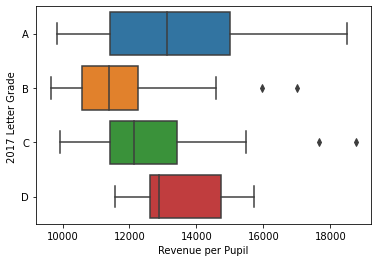

In [580]:
sns.boxplot(x=la_df["Revenue per Pupil"],y=la_df["2017 Letter Grade "],order=["A","B","C","D"])


Our intuition would tell us that the higher ranked schools would have a higher Revenue per Pupil, but upon further inspection we don't always see this to be true. While the median is highest in the highest ranked schools, we can see that the "B" rank schools actually have the lowest Revenue per Pupil ratio. Let's plot the average ACT score and graduation rate of each district to see how they place with respect to their revenue. The color of the point will represent their 2017 Letter Grade.

<AxesSubplot:xlabel='Raw ACT Score', ylabel='Total Revenue'>

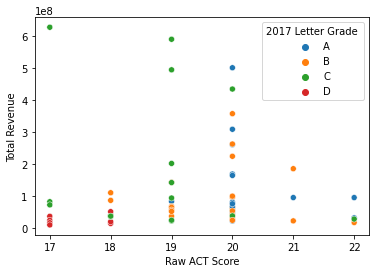

In [581]:
sns.scatterplot(y=la_df["Total Revenue"], x = la_df["Raw ACT Score"], data=la_df, hue=la_df["2017 Letter Grade "],hue_order=["A","B","C","D"])

<AxesSubplot:xlabel='Graduation Rate', ylabel='Total Revenue'>

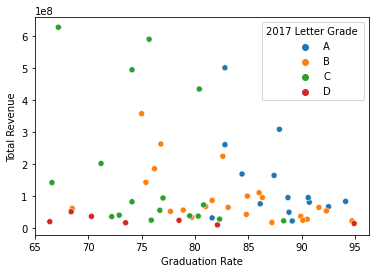

In [598]:
sns.scatterplot(y=la_df["Total Revenue"], x = la_df["Graduation Rate"], data=la_df, hue=la_df["2017 Letter Grade "],hue_order=["A","B","C","D"])

These tables shows that a higher revenue does not always mean a better education. Clearly we have an example of a school with a C rank, low graduation rate, and low ACT score having the highest revenue in the entire state. Let us now plot the average ACT score and graduation rate against the revenue per pupil.


<AxesSubplot:xlabel='Raw ACT Score', ylabel='Revenue per Pupil'>

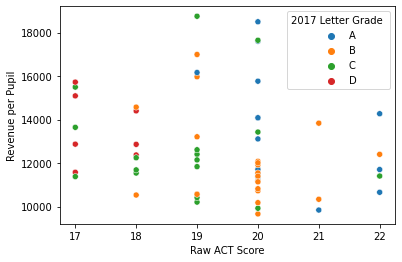

In [583]:
sns.scatterplot(y=la_df["Revenue per Pupil"], x = la_df["Raw ACT Score"], data=la_df, hue=la_df["2017 Letter Grade "],hue_order=["A","B","C","D"])

<AxesSubplot:xlabel='Graduation Rate', ylabel='Revenue per Pupil'>

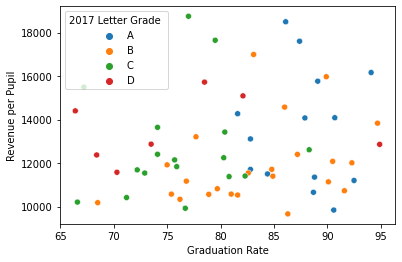

In [599]:
sns.scatterplot(y=la_df["Revenue per Pupil"], x = la_df["Graduation Rate"], data=la_df, hue=la_df["2017 Letter Grade "],hue_order=["A","B","C","D"])


We cannot say much in terms of Revenue per Pupil, ACT, and Graduation Rate as they do not seem to correlate much at all. Lets move to a state with a higher regarded education system to try and gain some insight.
___

## New Jersey: a Basis for Comparison
Let's take a look at another state's education data, namely New Jersey, which is a consistently ranked high by [reputable sources](https://www.nj.gov/governor/news/news/562021/20210309a.shtml) for their K-12 public education system. By investigating the relative differences between New Jersey and Louisiana's education systems, explanations for why Louisiana underperforms may be found. </br> </br>
Similar to the Louisiana data sets, we'll look into district demographics, financial information, and performance statistics to examine the attributes across school districts. It should be noted that New Jersey has, by far, more schools as a whole than Louisiana. This may contribute to slow processing speeds later on.

### New Jersey Budgets
Financial data for New Jersey public schools will be taken from the website of New Jersey's Department of Education. The data sets, along with a layout file, can be found [here](https://www.nj.gov/education/finance/fp/ufb/2016/download.shtml).

#### Revenues
Let's first take a look at revenues, or how much money each school district in New Jersey and Louisiana are bringing in from the local, state, and federal levels. </br>
We would expect that, on average, New Jersey public schools have more funding.

In [585]:
nj_rev_df = pd.read_csv(r'nj_rev.csv')
nj_rev_df = nj_rev_df[pd.notna(nj_rev_df["ACCOUNT"])] # Remove subtotal observations
nj_rev_df = nj_rev_df.drop(columns=["COUNTY_ID", "CONAME", "DISTRICT_ID", "LINE_NO", "ACCOUNT", "AMOUNT_2", "AMOUNT_3"])
nj_rev_df = nj_rev_df.rename(columns={"AMOUNT_1": "Revenue"})

In [586]:
nj_rev_df[:40]

,DISTNAME,LINE_DESC,Revenue
0,ABSECON CITY,Local Tax Levy,10921920.0
1,ABSECON CITY,Total Tuition,45081.0
2,ABSECON CITY,Unrestricted Miscellaneous Revenues,11041.0
3,ABSECON CITY,Interest Earned On Current Expense Emergency Res,5.0
4,ABSECON CITY,Interest Earned On Maintenance Reserve,0.0
5,ABSECON CITY,Interest Earned On Capital Reserve Funds,103.0
7,ABSECON CITY,Categorical Transportation Aid,59759.0
8,ABSECON CITY,Extraordinary Aid,19417.0
9,ABSECON CITY,Categorical Special Education Aid,507050.0
10,ABSECON CITY,Educational Adequacy Aid,77534.0


This is one example of a revenue stream for a singular district. To simplify, we will accumulate all of the revenue under one column.

In [587]:
# Group revenues together under one "Revenue" attribute
nj_rev_cube = nj_rev_df.pivot_table(
    index="DISTNAME",
    values="Revenue", aggfunc=np.sum)
nj_rev_cube.head()


,Revenue
DISTNAME,
ABSECON CITY,13397662.0
ALEXANDRIA TWP,10193006.0
ALLAMUCHY TWP,9709362.0
ALLENDALE BORO,16131608.0
ALLENHURST,255179.0


Much more neat and meaningful.

In [588]:
nj_mean = nj_rev_cube["Revenue"].mean()
print("New Jersey average total revenue:", nj_mean)

la_mean = la_df["Total Revenue"].mean()
print("Louisiana average total revenue:", la_mean)

New Jersey average total revenue: 44807097.16838488
Louisiana average total revenue: 119154596.77419356


From this, we can see that, on average, Louisiana school districts receive more funding than those in New Jersey.</br>
When we view histograms of each, we see that both states have a few outliers receiving a lot of funding, with most receiving a much lower portion:

<AxesSubplot:title={'center':'LA'}, ylabel='Frequency'>

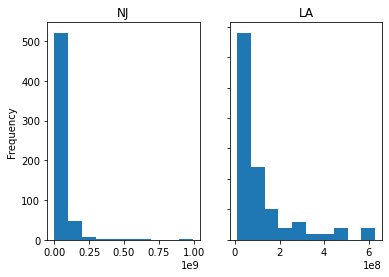

In [589]:
# https://stackoverflow.com/questions/45069828/how-to-plot-2-histograms-side-by-side
fig, axes = plt.subplots(1,2)

axes[0].set_title('NJ')
axes[1].set_title('LA')

nj_rev_cube["Revenue"].plot.hist(ax=axes[0], sharey=True)
la_df["Total Revenue"].plot.hist(ax=axes[1], sharey=True)

By examining these distributions as a box plot, we can get a better sense of how the data is distributed:

<AxesSubplot:>

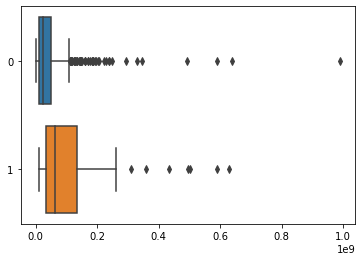

In [590]:
sns.boxplot(data=[nj_rev_cube["Revenue"].rename("NJ"), la_df["Total Revenue"].rename("LA")], orient="h")

From this, we can tell that Louisiana's funding is spread out better than New Jersey's, as New Jersey's box plot reveals many outliers. Let's look at revenue per pupil, next:

In [591]:
# Create enrollment dataframe
nj_enroll_df = pd.read_csv(r'nj_enroll.csv')
nj_enroll_df = nj_enroll_df[nj_enroll_df["ENROLL_CAT"] == "Onroll (Full)"] # Get just full amounts
nj_enroll_df.reset_index(inplace=True)
nj_enroll_df.drop(columns=["index", "COUNTY_ID", "CONAME", "DISTRICT_ID", "ENROLL_LINE_NO", "ENROLL_CAT", "AMOUNT_2", "AMOUNT_3"], inplace=True)
nj_enroll_df = nj_enroll_df.rename(columns={"AMOUNT_1":"Enrollment"})
nj_enroll_df.head()

,DISTNAME,Enrollment
0,ABSECON CITY,804.0
1,ATLANTIC CITY,6630.0
2,ATLANTIC CO VOCATIONAL,1226.0
3,BRIGANTINE CITY,635.0
4,BUENA REGIONAL,1604.0


In [592]:
# Create revenue/pupil column
nj_enroll_rev = nj_rev_cube.merge(nj_enroll_df, on=["DISTNAME"], suffixes=("rev", "enroll"))
nj_enroll_rev = nj_enroll_rev[nj_enroll_rev["Enrollment"] != 0]
nj_enroll_rev["rev/pupil"] = nj_enroll_rev["Revenue"] / nj_enroll_rev["Enrollment"]

In [593]:
print("NJ rev/pupil: ",nj_enroll_rev["rev/pupil"].mean())
print("LA rev/pupil:",la_df["Revenue per Pupil"].mean())

NJ rev/pupil:  79844.84968801291
LA rev/pupil: 12694.709677419354


<AxesSubplot:>

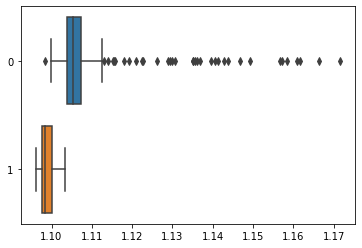

In [594]:
# Transform rev/pupil attribute
nj_enroll_rev["log(rev/pupil)"] = np.log(nj_enroll_rev["rev/pupil"])
la_df["log(Revenue per Pupil)"] = np.log(la_df["Revenue per Pupil"])
sns.boxplot(data=[(nj_enroll_rev["rev/pupil"]**.01).rename("NJ"), (la_df["Revenue per Pupil"]**.01).rename("LA")], orient="h")

From the above, we can see that the average rate of revenue per pupil is much higher for New Jersey school districts than for Louisiana school districts. The two metrics we've looked at, average total revenue and average total revenue per pupil, indicate opposing results. Let's incorporate a metric of academic performance or success, such as graduation rate, to determine whether either of these correllate with academic performance.

#### Revenue and Graduation Rate
New Jersey Enrollment data, as published by New Jersey's Department of Education, can be found [here](https://www.nj.gov/education/schoolperformance/grad/ACGR.shtml) under "2016 Adjusted Cohort 4 year Graduation rates (Excel)"

In [595]:
# Load in New Jersey Graduation data, convert to proper dtypes
nj_grad_df = pd.read_csv(r'nj_grad.csv')
nj_grad_all = nj_grad_df[nj_grad_df["SUBGROUP"] == "Districtwide"]
nj_grad_all.reset_index(inplace=True)
nj_grad_all = nj_grad_all.drop(columns=["index", "COUNTY_ID", "COUNTY_NAME", "DISTRICT_ID", "SCHOOL_CODE", "SCHOOL_NAME", "SUBGROUP", "Unnamed: 10"])

grad_nums = pd.to_numeric(nj_grad_all["FOUR_YR_GRAD_RATE"], errors="coerce", downcast="integer")
grad_df = pd.DataFrame(grad_nums)
nj_grad_all.pop("FOUR_YR_GRAD_RATE")
nj_grad_all = nj_grad_all.join(grad_df)

grad_nums = pd.to_numeric(nj_grad_all["FOUR_YR_ADJ_COHORT_COUNT"], errors="coerce", downcast="integer")
grad_df = pd.DataFrame(grad_nums)
nj_grad_all.pop("FOUR_YR_ADJ_COHORT_COUNT")
nj_grad_all = nj_grad_all.join(grad_df)

grad_nums = pd.to_numeric(nj_grad_all["GRADUATED_COUNT"], errors="coerce", downcast="integer")
grad_df = pd.DataFrame(grad_nums)
nj_grad_all.pop("GRADUATED_COUNT")
nj_grad_all = nj_grad_all.join(grad_df)

grad_nums = pd.to_numeric(la_df["Graduation Rate"], errors="coerce", downcast="integer")
grad_df = pd.DataFrame(grad_nums)
la_df.pop("Graduation Rate")
la_df = la_df.join(grad_df)


In [596]:
print("New Jersey average graduation rate:", nj_grad_all["FOUR_YR_GRAD_RATE"].mean())
print("Louisiana average graduation rate:", la_df["Graduation Rate"].mean())


New Jersey average graduation rate: 91.09950657894736
Louisiana average graduation rate: 81.5016393442623


#### Appropriations

In [597]:
nj_approp_df = pd.read_csv(r'nj_approp.csv')
nj_approp_df.head()

,county_id,county_name,district_id,district_name,line_no,account,line_desc,amount_1,amount_2,amount_3
0,1,Atlantic,10,Absecon City,3200,'11-1XX-100-XX,Total Regular Programs-Instruction,4235829.0,4719675.0,4869078.0
1,1,Atlantic,10,Absecon City,10300,'11-2XX-100-XX,Total Special Education-Instruction,1190214.0,1098415.0,1215532.0
2,1,Atlantic,10,Absecon City,11160,'11-230-100-XX,Total Basic Skills/Remedial-Instruction,95576.0,250.0,58314.0
3,1,Atlantic,10,Absecon City,12160,'11-240-100-XX,Total Bilingual Education-Instruction,150307.0,158866.0,172240.0
4,1,Atlantic,10,Absecon City,17100,'11-401-100-XX,Total School-Sponsored Cocurricular or Extracu...,63181.0,46224.0,62200.0


___
## Closing Thoughts and Final Goals:
The team is also interested in what relationships the two datasets have with each other, considering they cover different aspects of the same units of observations, those being demographic measurements and performance measurements. Questions such as: <br/>
  - What are the demographics of schools that perform best/worst? <br/>
  - How do compensation rates compare between well and poorly performing schools? <br/> 
  - How relevant is the pupil/teacher ratio in academic performance?” <br/>
  - Does school size have any impact on graduation rate or academic performance? <br/>
 
 These are the questions the team is most interested in: the ones that relate to both datasets and will require the merging and/or comparing of the two, rather than just looking at each individually. Eventually, the team would like to create a model based on the data from these tables to predict the test scores of districts around the country based on their information from the U.S. Department of Education National Center for Education Statistics Common Code of Data (CCD). This would, of course, requires more datasets to be parsed and tidied – which would be done once our initial exploratory analysis is completed.